This notebook is a nearly exact copy of a [fastai2 tutorial](https://github.com/fastai/fastai2/blob/master/nbs/23_tutorial.transfer_learning.ipynb) but reproduced in the context of sound classification.

In [1]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
trn_df = pd.read_csv('data/train.csv')

trn_paths = list(Path('data/img_train_22k_2sec_better_centered_linear_linear/').iterdir())
tst_paths = list(Path('data/img_test_22k_2sec_better_centered_linear_linear/').iterdir())

splits = pd.read_pickle('data/splits.pkl')

In [3]:
trn_df.fname = trn_df.fname.apply(lambda x: x.split('.')[0] + '.png')

In [4]:
trn_df.head()

,fname,label,manually_verified
0,00044347.png,Hi-hat,0
1,001ca53d.png,Saxophone,1
2,002d256b.png,Trumpet,0
3,0033e230.png,Glockenspiel,1
4,00353774.png,Cello,1


In [5]:
trn_df.set_index('fname', inplace=True);

In [6]:
trn_df.head()

,label,manually_verified
fname,,
00044347.png,Hi-hat,0
001ca53d.png,Saxophone,1
002d256b.png,Trumpet,0
0033e230.png,Glockenspiel,1
00353774.png,Cello,1


In [7]:
lbl_dict = trn_df.to_dict()['label']

In [8]:
def path2fn(path): return path.name

In [9]:
tfms = [[PILImage.create], [path2fn, lbl_dict.__getitem__, Categorize()]]
item_img_tfms = [ToTensor()]

In [10]:
dsrc = DataSource(trn_paths, tfms, splits=splits[0])

In [11]:
NUM_WORKERS=12
BS=64

batch_tfms = [Cuda(), IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
dbch = dsrc.databunch(after_item=item_img_tfms, after_batch=batch_tfms, bs=BS, num_workers=NUM_WORKERS)

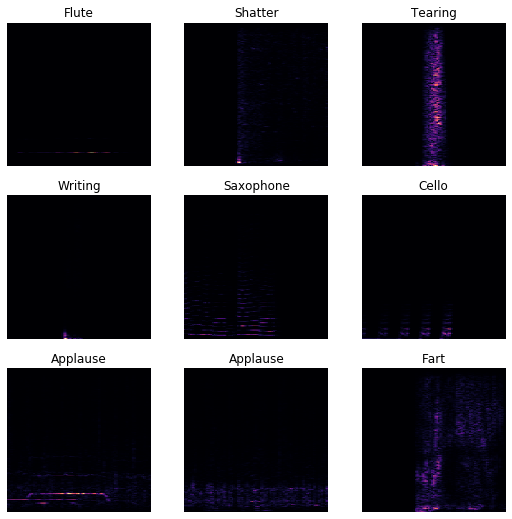

In [12]:
dbch.show_batch(max_n=9)

In [13]:
from torchvision.models import resnet34

In [14]:
opt_func = partial(Adam, lr=slice(3e-3), wd=0.01, eps=1e-8)

In [15]:
def top_3_accuracy(preds, targs): return top_k_accuracy(preds, targs, 3)

In [16]:
learn = cnn_learner(dbch, resnet50, opt_func=opt_func, metrics=[accuracy, top_3_accuracy], config=cnn_config(ps=0.33))

In [17]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,2.402176,1.844865,0.497140,0.729589,00:36


In [18]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,1.723191,1.444867,0.590224,0.805512,00:44


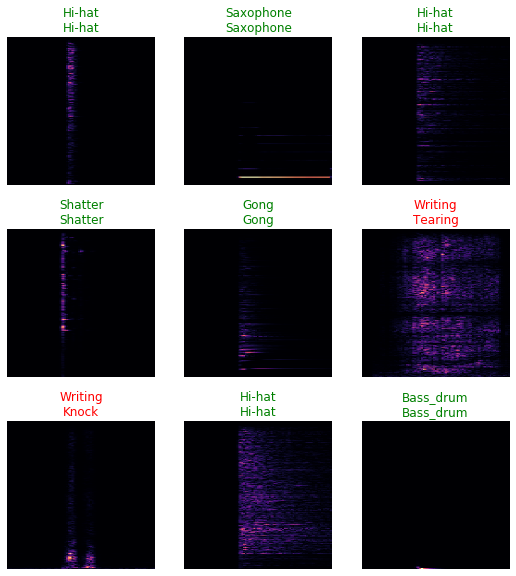

In [19]:
learn.show_results(max_n=9)

In [20]:
interp = Interpretation.from_learner(learn)

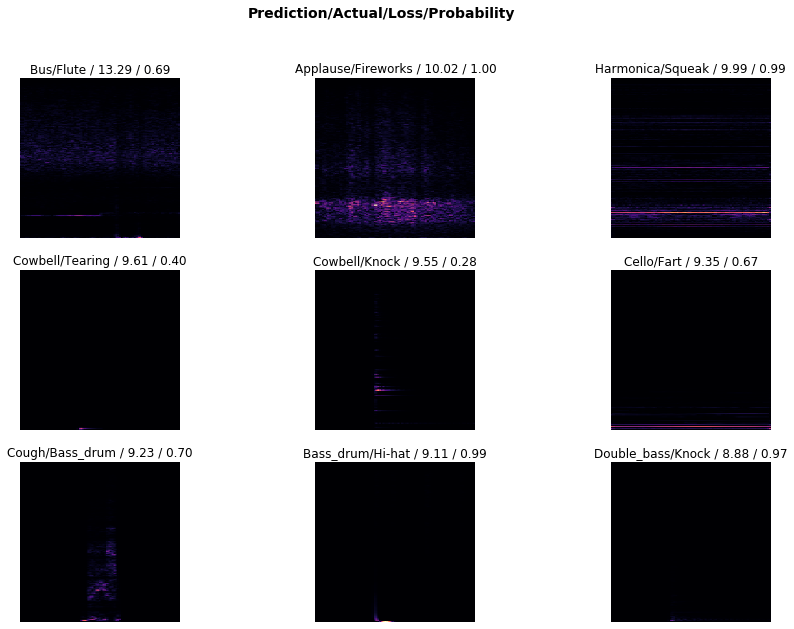

In [21]:
interp.plot_top_losses(9, figsize=(15,10))

In [22]:
preds = learn.get_preds(dl=test_dl(dbch, tst_paths))[0]

In [23]:
predicted_label_idxs = preds.argsort(descending=True)[:, :3]

In [24]:
fns, predicted_labels = [], []

for path, idxs in zip(tst_paths, predicted_label_idxs):
    fns.append(path.stem + '.wav')
    predicted_labels.append([dbch.vocab[idx] for idx in idxs])

In [25]:
sub = pd.DataFrame({'fname': fns, 'label': predicted_labels})
sub.label = sub.label.apply(lambda lst: ' '.join(lst))

In [26]:
sub.head()

,fname,label
0,4c64aea6.wav,Bass_drum Double_bass Cowbell
1,190f0ca0.wav,Clarinet Flute Oboe
2,d1a257ee.wav,Trumpet Violin_or_fiddle Oboe
3,73ff824e.wav,Oboe Clarinet Flute
4,ffa69cfc.wav,Oboe Flute Clarinet


In [27]:
sub_name = 'res34_linear_linear'
sub.to_csv(f'data/submissions/{sub_name}.csv.zip', compression='zip', index=False)

In [28]:
!kaggle competitions submit -c freesound-audio-tagging -f data/submissions/{sub_name}.csv.zip -m {sub_name}

100%|██████████████████████████████████████| 90.6k/90.6k [00:02<00:00, 31.4kB/s]
Successfully submitted to Freesound General-Purpose Audio Tagging Challenge